# Natural Language Processing using parallelization via PySpark

_Note: You're currently reading the work of a single contributor. Please refer to [Matt's folder](https://github.com/Galeforse/DST-Assessment-05/tree/main/Matt%20Corrie) for **prior** instructions on Pyspark, as well as [Gab's](https://github.com/Galeforse/DST-Assessment-05/tree/main/Gabriel%20Grant) folder for the rest of our work. Thank you!_

In this project our team's goal is to achieve notable reductions in time complexity of our NLP(Natural Language Processing) model of choice via means of parallelization. The analysis is performed in 3 instances: One non-parallelized, one parallelized via MultiCore processing and one parallelized via PySpark. We aim to compare the three methods and hopefully observe how they gradually outperform one another. The dataset we perform these on is a webscrapped version of the [NCSC Daily News Reports](https://www.ncsc.gov.uk/section/keep-up-to-date/threat-reports?q=&defaultTypes=report&sort=date%2Bdesc&writtenFor=Large+organisations) up to the 23rd of April 2021. Dates beyond that are not included in this analysis. The NLP model studied in this paper is the TF-IDF Bag of Words Model (Term Frequency - Inverse Document Frequency). The paper omits any EDA(Exploratory Data Analysis) since the dataset is manually constructed from a known and reliable source, presenting no corruption or missingness. Therefore, the sections followed by this paper are:


1. Pre-requisites


2. TF-IDF implementation

    2.1 Using a single worker
    
    2.2 Using MultiCore processing


3. Setting up pyspark


4. TF-IDF implementation using PySpark


5. Conclusions

Let's start with what we need to import:

## 1. Pre-requisites

We need to import the following library for PySpark before anything else. For more details on the process, visit [Matt's](https://github.com/Galeforse/DST-Assessment-05/tree/main/Matt%20Corrie) folder:

In [1]:
import findspark
findspark.init()

We also need the following:

In [2]:
import datetime
import pickle
from urllib.request import urlopen
import os
import pandas as pd
import numpy as np
import gensim
import pickle
import matplotlib.pyplot as plt

import heapq

Let us load the dataset and run a summary of it:

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Galeforse/DST-Assessment-05/main/Data/NCSC%20Reports.csv')

In [4]:
df.head()

,Unnamed: 0,Title,Article,topics,Links
0,0,23rd April 2021,['The NCSC is aware that a malicious piece of ...,"['Cyber attack', 'Cyber strategy', 'Education'...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,1,16th April 2021,['Cyber security researchers have uncovered a ...,"['Cyber strategy', 'Patching', 'Vulnerabilities']",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,2,12th April 2021,"['Cyber security researchers, Esentire, have w...","['Phishing', 'Social media', 'Personal data', ...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,3,2nd April 2021,['The UK education sector continues to face an...,"['Education', 'Incident management', 'Secure d...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,4,26th March 2021,['Earlier this month Microsoft confirmed that ...,"['Cyber attack', 'Education', 'Mitigation', 'P...",https://www.ncsc.gov.uk/report/weekly-threat-r...


In [5]:
print(np.shape(df))

(221, 5)


This is what a typical article within the dataset looks like:

In [6]:
df.iloc[4,2]

"['Earlier this month Microsoft confirmed that sophisticated actors had attacked a number of Exchange servers and have released multiple security updates since.\\nThe NCSC is strongly urging any organisation using affected versions to proactively search their system for evidence of compromise, in line with Microsoft guidance.\\nOur alert was updated last week with the most recent advice and guidance.', 'A new report has revealed that almost 40% of UK businesses experienced a cyber attack last year.', 'The Cyber Security Breaches Survey 2021 report, published by the Department of Digital, Culture, Media and Sport (DCMS), also revealed that a quarter of charities have suffered a cyber security breach or attack in the past 12 months.', 'The NCSC has produced guidance to address some of the most common breaches and attacks identified in the report:\\nphishing emails\\nviruses\\nransomware\\nWhere a breach has resulted in a loss of data or assets, the average cost of a cyber attack on a bus

To run an NLP model, we will need to normalize and lemmatize our text. To do so, we will use a library called 'nltk':

In [7]:
import nltk

Unless the 'stopwords' and the english 'words' list have been previously downloaded on your local device from nltk, you will need to uncomment the following 2 lines. Afterwards, we need to import the corresponding lists so we can use them:

In [8]:
# nltk.download('stopwords')
# nltk.download('words')

from nltk.corpus import stopwords

We save the stopwords in a list so we can eliminate them from our text, as they add noise to the modelling. We will space them out left and right to delimitate them as words. Moreover, we took the freedom of adding a couple more of redundant words to the list.

In [9]:
l1 = stopwords.words('english')
l2 = ['have', 'with', 'cannot', 'all', 'more', 'less', 'fewer', 'if', 'from', 'new', 'old', 'be', 'This']
l1.append(l2)
lst1 = [' {} '.format(x) for x in l1]

len(lst1)

180

We will then remove all words within the list from out text, as well as any phrasing characters (.,:" etc.) and numbers from 0 to 99999... :

In [10]:
df['Article'].replace(lst1, " ", regex=True, inplace=True)
df['Article'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
df['Article'].replace('[0-9999999999]', " ", regex=True, inplace=True)

This is what the same article as before looks like now:

In [11]:
df.iloc[4,2]

'  Earlier month Microsoft confirmed sophisticated actors attacked number Exchange servers released multiple security updates since  nThe NCSC strongly urging organisation using affected versions proactively search system evidence compromise  line Microsoft guidance  nOur alert updated last week recent advice guidance     A new report revealed almost     UK businesses experienced cyber attack last year     The Cyber Security Breaches Survey      report  published Department Digital  Culture  Media Sport  DCMS   also revealed quarter charities suffered cyber security breach attack past    months     The NCSC produced guidance address common breaches attacks identified report  nphishing emails nviruses nransomware nWhere breach resulted loss data assets  average cost cyber attack business         This figure rises         medium large businesses  nThe report also shows cyber risk organisations heightened pandemic  made securing digital environments challenging resources diverted facilita

The now cleaned text is ready for lemmatization. To do that, we will define a tokenizer using the same 'nltk' library as for the stopwords:

In [12]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

Finally, we define the lemmatization:

In [13]:
# nltk.download('wordnet')
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

We now apply it to our text and output the result, which should be a frame of lemmatized, normalized words:

In [14]:
df_lem = df['Article'].apply(lemmatize_text)

In [15]:
df_lem

0      [The, NCSC, aware, malicious, piece, spyware, ...
1      [Cyber, security, researcher, uncovered, serie...
2      [Cyber, security, researcher, Esentire, warned...
3      [The, UK, education, sector, continues, face, ...
4      [Earlier, month, Microsoft, confirmed, sophist...
                             ...                        
216    [Malware, infected, ATMs, compromise, Indian, ...
217    [Threat, assessment, trend, analysis, nOnline,...
218    [New, Trojan, used, financial, attack, nSymant...
219    [Threat, assessment, trend, analysis, nDressco...
220    [Threat, assessment, trend, analysis, nYahoo, ...
Name: Article, Length: 221, dtype: object

We need to make sure the output is a list for the final step:

In [16]:
df_lem_list = df_lem.values.tolist()

Lastly, we extract all the words which have length greater than 4 characters, so we don't pick up any remaining connection words like 'a' or 'the', AND those which represent acronyms, as they are certain to be crucial for topic modelling, such as HTTP, ATP or NCSC. These will represent our dictionary which will then be used for the implementation of our bag of words (BoW) model:

In [17]:
lister = [[] for x in range(len(df_lem))]
for i in range(len(df_lem_list)):
    l = df_lem_list[i]
    for token in l:
        if (len(token)>4 or token.isupper()):
            lister[i].append(token)

lister[0:1]

[['NCSC',
  'aware',
  'malicious',
  'piece',
  'spyware',
  'known',
  'FluBot',
  'affecting',
  'Android',
  'phone',
  'device',
  'across',
  'UK',
  'spyware',
  'installed',
  'victim',
  'receives',
  'message',
  'asking',
  'install',
  'tracking',
  'missed',
  'package',
  'delivery',
  'nScammers',
  'cyber',
  'criminal',
  'regularly',
  'exploit',
  'known',
  'trusted',
  'brand',
  'personal',
  'FluBot',
  'campaign',
  'prime',
  'example',
  'nAndroid',
  'urged',
  'familiarise',
  'guidance',
  'vigilant',
  'suspicious',
  'looking',
  'message',
  'forwarded',
  'Earlier',
  'FireEye',
  'published',
  'saying',
  'APT',
  'actor',
  'actively',
  'exploiting',
  'vulnerability',
  'Pulse',
  'Connect',
  'VPN',
  'appliance',
  'follows',
  'security',
  'update',
  'Pulse',
  'Secure',
  'recently',
  'discovered',
  'limited',
  'number',
  'customer',
  'experienced',
  'evidence',
  'exploit',
  'behaviour',
  'Pulse',
  'Connect',
  'Secure',
  'PCS',
  

In [19]:
type(lister)

list

In [23]:
pickle.dump(lister, open('wordlist.p','wb'))

We're now ready to start the TF-IDF implementation:

## 2. TF-IDF Implementation

**2.1 Using a single worker**

This subsection deals with all the pre-requisites necessary for our modelling. It then trivially implements the optimization stage where we look for the best model using a single worker. That stage is the one we'll be mainly interested in when it comes to comparing results with its parallelized variant. The results we'll be using, however, are the ones we'll get in subsection 2.2 where we implement the model using MultiCore processing.

Before all these, let us define our dictionary and the corpus:

In [24]:
dictionary = gensim.corpora.Dictionary(lister)

In [25]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lister]
tfidf=gensim.models.TfidfModel(bow_corpus)
tfidf_corp = tfidf[bow_corpus]

We output a sample of the corpus:

In [26]:
bow_corpus[0:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 3),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 3),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 3),
  (21, 1),
  (22, 4),
  (23, 1),
  (24, 3),
  (25, 2),
  (26, 2),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 2),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 2),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 3),
  (47, 1),
  (48, 5),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 2),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 2)

Finally, let's load the model at a randomly chosen amount of topics. This merely tests that the model works. Afterwards, the main concern will be identifying the optimal number of topics, which will take most of the computational power:

In [21]:
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corp, num_topics=6, id2word=dictionary, passes=2, workers=4)

We'll need the following for visualization:

In [22]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [23]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display, template_type='notebook')

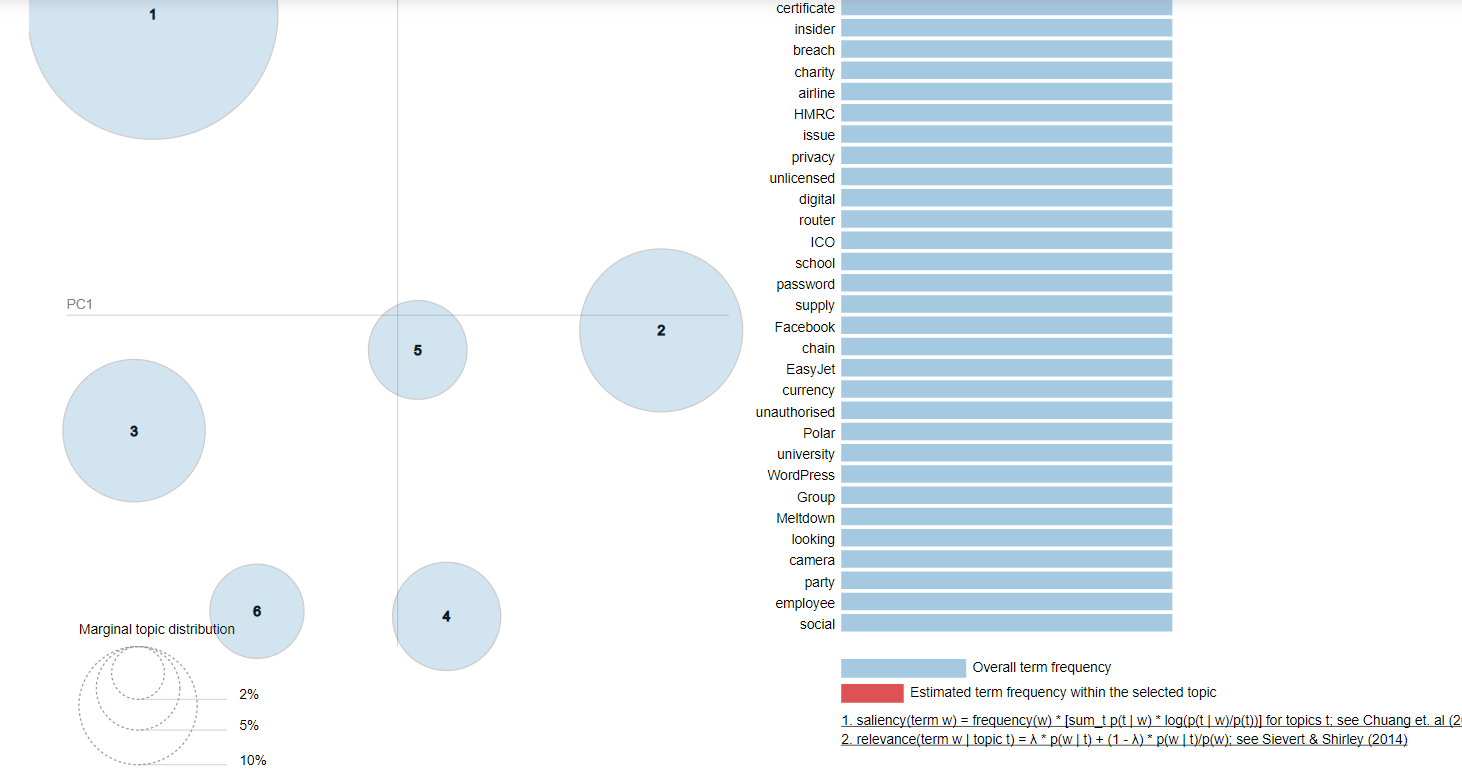

To identify what works best, we look for the maximum coherence with the minimum perplexity, where possible. Where not possible, the measurement of coherence outweighs perplexity in priority. We'll load a function to measure the former, as the latter already presents an built-in implementation via gensim:

In [24]:
from gensim.models.coherencemodel import CoherenceModel
def getCoherence(m,t,d):
    coherence_model_lda = CoherenceModel(model=m,texts=t, dictionary=d, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return(coherence_lda) # Need high coherence

We now compute them for our random choice of (six) topics:

In [25]:
getCoherence(m=lda_model_tfidf, t=lister, d =dictionary)

0.3395650525112139

In [26]:
perplex = lda_model_tfidf.log_perplexity(tfidf_corp)

In [27]:
perplex

-11.67374977984347

Lastly, we initialize the loop algorithm for finding the number of topics we ought to pick. We do so on a single worker, i.e. non-parallelized. The time complexity of this loop will then be measured and output at the end: 

In [28]:
begin_time = datetime.datetime.now()
gCH = [0] * 50
for i in range(1,50):
    locals()['lda_model_tfidf_{}'.format(i)] = gensim.models.LdaMulticore(tfidf_corp, num_topics=i, id2word=dictionary, passes=2, workers=1)
    gCH[i]=getCoherence(m=locals()['lda_model_tfidf_{}'.format(i)], t=lister, d =dictionary)
end_time = datetime.datetime.now()
time_weak_coh = (end_time - begin_time)

print(time_weak_coh)

0:10:13.528705


The process ran in a bit over 10 minutes. Let's see if our trivial alternative performs better. 

**2.2 Using multiple workers**

We'll now try the exact same algorithm, except using MultiCore processing on 4 workers instead. We do _not_ expect a massive decrease in time complexity, but at least a noticeably one:

In [30]:
begin_time = datetime.datetime.now()
gCH = [0] * 50
for i in range(1,50):
    locals()['lda_model_tfidf_{}'.format(i)] = gensim.models.LdaMulticore(tfidf_corp, num_topics=i, id2word=dictionary, passes=2, workers=4)
    gCH[i]=getCoherence(m=locals()['lda_model_tfidf_{}'.format(i)], t=lister, d =dictionary)
end_time = datetime.datetime.now()
time_coh = (end_time - begin_time)

print(time_coh)

0:09:47.233116


We cut the time down to slightly under 10 minutes. As expected, it's not a great way to parallelize. The reason for this outcome is up to debate, however we have some intuitions. Perhaps the MultiCore processing in this case isn't entirely suited for the task of NLP, and as such is unsure for the most part on how to distribute the workers. It's clearly not parallelizing the articles, as we'd hope for it to, but instead potentially parallelizing the TF-IDF algorithm (e.g. computing the TF and the IDF simultaneously, in parallel). Optimized, these 2 computations should have a complexity no greater than O(nlog(n)) which, for the small size of our dataset, will be very quick to compute. Therefore, computing them at once rather than sequentially results in a very small increase, less than 1second per article, as the results show.

In terms of perplexity, the existence of a built-in function will make the computation really quick:

In [31]:
begin_time = datetime.datetime.now()
perplexity = [0] * 50
for i in range(1,50):
    perplexity[i]=locals()['lda_model_tfidf_{}'.format(i)].log_perplexity(tfidf_corp)
end_time = datetime.datetime.now()
time_perp = (end_time - begin_time)

print(time_perp)

0:00:27.713458


Let us plot the results:

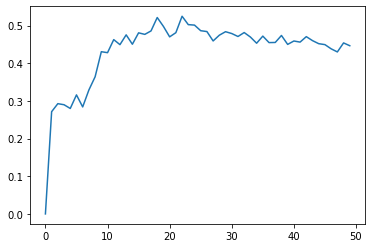

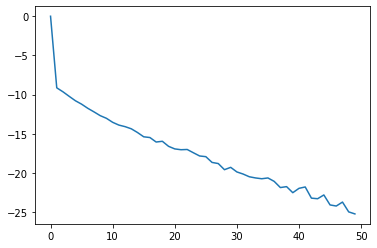

In [32]:
plt.plot(gCH)
plt.show()
plt.plot(perplexity)
plt.show()

Finally, let's find out what amount of topics gives the best coherence for our model:

In [33]:
print("The maximum coherence achieved is", max(gCH), "and its corresponding number of topics is", np.argmax(gCH))
print("The minimum perplexity achieved is", min(perplexity), "and its corresponding number of topics is", np.argmin(perplexity))

The maximum coherence achieved is 0.5249285854457164 and its corresponding number of topics is 22
The minimum perplexity achieved is -25.240321626435403 and its corresponding number of topics is 49


We'll visualize them as before:

In [34]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf_22, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display, template_type='notebook')

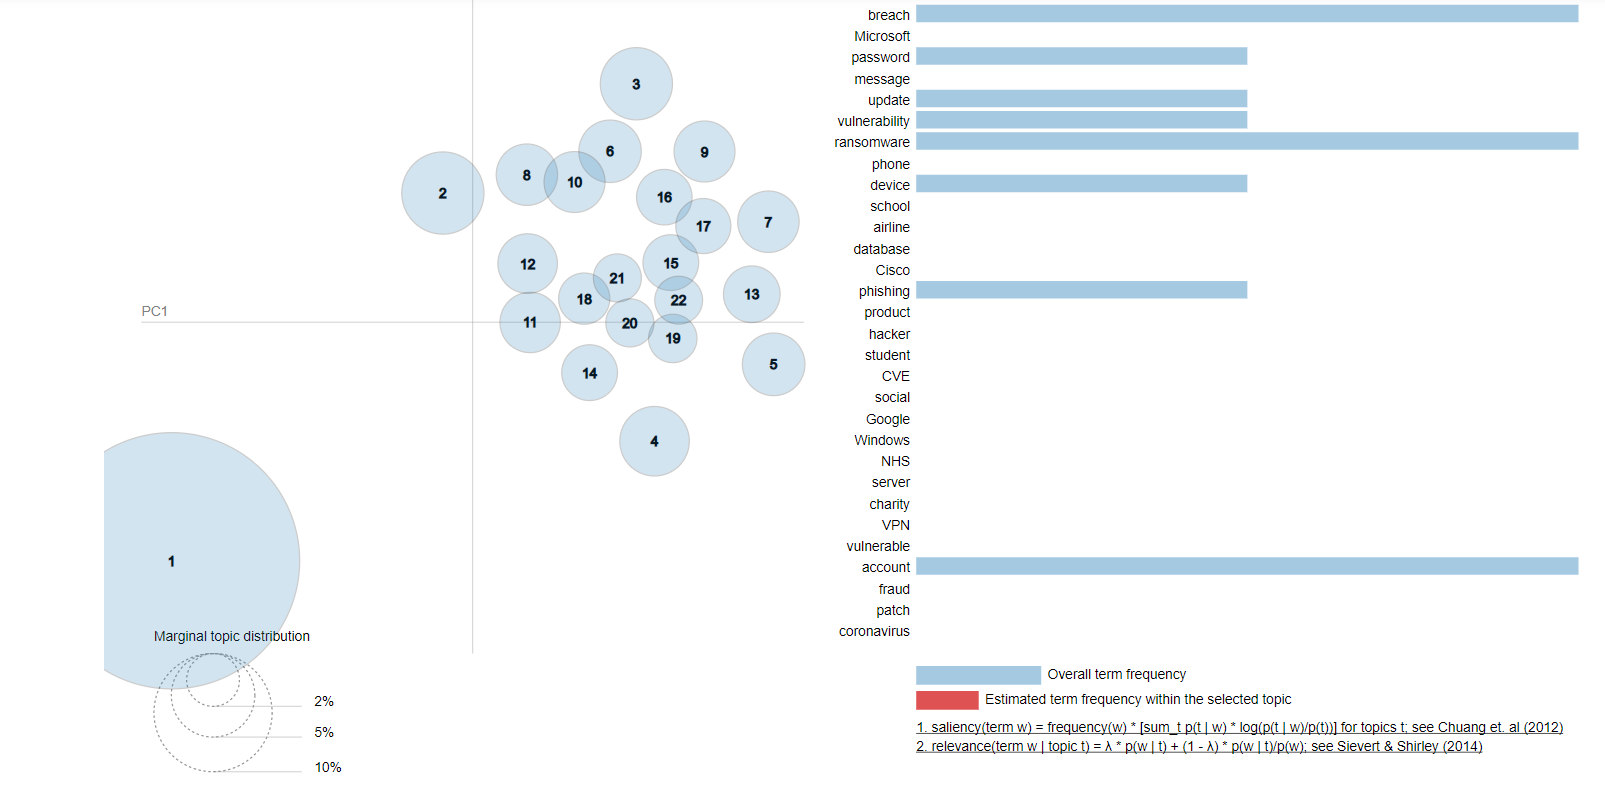

Let's explore an alternative way to parallelize:

## 3. Setting up PySpark

In this section we aim to get the pre-requisites for PySpark to run. We'll then use it to construct a pipeline and finally parallelize our model using SparkNLP. First, however, the reader will need a few things. Do visit [this](https://github.com/Galeforse/DST-Assessment-05/tree/main/Matt%20Corrie) for more instructions on PySpark.

The following need to be installed in order for sparkNLP to work on your device. The first 2 lines might _not work_ directly, in which case they need to be run within the CommandPrompt if using Windows, or, alternatively, AnacondaPrompt/Miniconda. The 3rd line needs uncommenting and to be ran as well.

In [35]:
# conda create -n sparknlp python=3.7 -y
# conda activate sparknlp
# !pip install spark-nlp==3.0.2 pyspark==3.1.1

We need to import the following as well. The second line will start our spark session!

In [29]:
import sparknlp
sparknlp = sparknlp.start()

In [30]:
type(sparknlp)

pyspark.sql.session.SparkSession

The following are required for constructing the pipeline. The next block of code is what we used in Section 2 as well, for importing English words and stopwords from 'nltk'.

In [31]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                Lemmatizer, LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words

We now define our stopwords:

In [33]:
eng_stopwords = stopwords.words('english')
eng_words = words.words()

The following properties, each linking to the next one will become our pipeline. 

**Note:** The lemmatizer is _NOT_ used in this paper. The reason for that is that we couldn't get it working. However, our final results were in no way hindered by this inconvenience, as it can easily be seen at the end. The reason for this (otherwise lucky!) outcome is that words used in our dataset required no lemmatization for the most part - at least not those of sufficient TF-IDF standard importance that they would influence their supersetting topics.

Several ways to implement the lemmatizer were attempted. Two different dictionaries (and their corresponding attempts which are commented below) can still be found in a subfolder, [here](https://github.com/Galeforse/DST-Assessment-05/tree/main/Alex%20Caian/Dictionary) and [here](https://github.com/Galeforse/DST-Assessment-05/tree/main/Alex%20Caian/lemma_antbnc_en_2.0.2_2.4_1556480454569) respectively. The reader is free to uncomment them, download the dictionaries and set the locals accordingly as we have attempted at their own expense. However, as we mentioned, this won't influence the final outcome (almost) at all.

In [34]:
documentAssembler = DocumentAssembler() \
     .setInputCol('Article') \
     .setOutputCol('Articles')

tokenizer = Tokenizer() \
     .setInputCols(['Articles']) \
     .setOutputCol('token')

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

# lemmatizer = LemmatizerModel.load('lemma_antbnc_en_2.0.2_2.4_1556480454569') \
 #   .setInputCols(['normalized']) \
 #   .setOutputCol('lemma') \

# lemmatizer = Lemmatizer() \
 #    .setInputCols(['normalized']) \
 #    .setOutputCol('lemma') \
 #    .setDictionary("AntBNC_lemmas_ver_001.txt", value_delimiter="\t", key_delimiter="->")

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['normalized']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(eng_stopwords)

finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

Finally, we construct the pipeline:

In [35]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
          #  lemmatizer,
          stopwords_cleaner,
          finisher
     ])

The last thing we need to do is read our dataset within the Spark context we have set. Very little of the code below will be spark code rather than python:

In [11]:
df.to_csv('NCSC Reports.csv')

In [36]:
dfs = sparknlp.read.load("NCSC Reports.csv",format='csv', header = "true")

In [37]:
dfs.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- topics: string (nullable = true)
 |-- Links: string (nullable = true)



In [14]:
pd.DataFrame(dfs.take(10), columns=dfs.columns)

,_c0,Unnamed: 0,Title,Article,topics,Links
0,0,0,23rd April 2021,['The NCSC is aware that a malicious piece of ...,"['Cyber attack', 'Cyber strategy', 'Education'...",https://www.ncsc.gov.uk/report/weekly-threat-r...
1,1,1,16th April 2021,['Cyber security researchers have uncovered a ...,"['Cyber strategy', 'Patching', 'Vulnerabilities']",https://www.ncsc.gov.uk/report/weekly-threat-r...
2,2,2,12th April 2021,"['Cyber security researchers, Esentire, have w...","['Phishing', 'Social media', 'Personal data', ...",https://www.ncsc.gov.uk/report/weekly-threat-r...
3,3,3,2nd April 2021,['The UK education sector continues to face an...,"['Education', 'Incident management', 'Secure d...",https://www.ncsc.gov.uk/report/weekly-threat-r...
4,4,4,26th March 2021,['Earlier this month Microsoft confirmed that ...,"['Cyber attack', 'Education', 'Mitigation', 'P...",https://www.ncsc.gov.uk/report/weekly-threat-r...
5,5,5,19th March 2021,['Courier service company Fastway said this we...,"['Cyber attack', 'Personal data', 'Phishing', ...",https://www.ncsc.gov.uk/report/weekly-threat-r...
6,6,6,12th March 2021,['There has been a rise in vulnerability repor...,"['Cyber threat', 'Risk management', 'Vulnerabi...",https://www.ncsc.gov.uk/report/weekly-threat-r...
7,7,7,5th March 2021,['Microsoft has released a number of security ...,"['Cyber threat', 'Patching', 'Personal data', ...",https://www.ncsc.gov.uk/report/weekly-threat-r...
8,8,8,26th February 2021,['VMware have released security updates to add...,"['Cyber attack', 'Vulnerabilities']",https://www.ncsc.gov.uk/report/weekly-threat-r...
9,9,9,19th February 2021,"['Scam emails, which aim to convince people to...","['Cyber attack', 'Personal data', 'Phishing', ...",https://www.ncsc.gov.uk/report/weekly-threat-r...


The following extension _should_ be installed by default with Java. However, it's worth checking if you have it. Otherwise, please uncomment and run this code:

In [15]:
# conda install -c cyclus java-jdk 

Finally, we fit the pipeline to the dataframe and output the resulting features:

In [16]:
NCSC_pipeline = pipeline.fit(dfs).transform(dfs)

In [17]:
NCSC_pipeline.columns

['_c0',
 'Unnamed: 0',
 'Title',
 'Article',
 'topics',
 'Links',
 'Articles',
 'token',
 'normalized',
 'clean_lemma',
 'finished_clean_lemma']

We'll also need to fit the adjustments we've set up for our data (i.e. normalized, tokenized etc.) to the pipeline:

In [18]:
from pyspark.sql.functions import explode, col

In [19]:
NCSC_pipeline.select('finished_clean_lemma')

DataFrame[finished_clean_lemma: array<string>]

Finally, we setup the words:

In [20]:
NCSC_pipeline_words = NCSC_pipeline.withColumn('exploded_text', 
                               explode(col('finished_clean_lemma')))

In [21]:
counts = NCSC_pipeline_words.groupby('exploded_text').count()
counts_pd = counts.toPandas()
NCSC_pipeline_dict = {counts_pd.loc[i, 'exploded_text']: 
                counts_pd.loc[i, 'count'] 
                for i in range(counts_pd.shape[0])}

With the pipeline and SparkNLP environment setup, we're ready to implement the parallelized version of TF-IDF.

## 4. TF-IDF implementation using PySpark

The 'Article' feature is what we're mainly interested in, which is already specified and targeted within the Pipeline. We'll also make use of the 'Title' section, which corresponds to the dates when the articles were released. This section will be useful in looping through the articles for PySpark, so it knows what to work on in parallel.

In [22]:
Dates = df['Title'].tolist()

In [23]:
report_counts_dict = {date: {} for date in Dates}

We have now set the dates. The next **5 blocks** of code are meant to be run all at once if you want to achieve a correct measurement of how long the whole process takes when parallelized. This is due to how we set up the 'beginning_time' and 'ending_time' of the process. Failure to run them immediately in sequence may results in a time output larger than the real time it took the process to finish. Running them 'one after the other' rather than 'all at once' will perhaps add a couple of seconds to the process as we exemplify at the end.

The following blocks functionally do everything our LDAMultiCore version in section 2 did. The first block defines our dictionary and corpus, the next one (which essentially takes no time to run) manually implements TF and IDF. The last ones output the topics for each article with the corresponding TF-IDF score for each structurally relevant word (up to a hard-set maximum of 10 words per article). In most articles between 2-4 words will be output. The final block executes the end on the timer, outputting the result we're interested in: how long did it take to run the parallelized TF-IDF? 

With these specifications, let us run it:

In [24]:
begin_time = datetime.datetime.now()
for date in Dates:
    # print(date)
    date_df = dfs.filter((dfs['Title'] == date) & (dfs['Article'].isNull() == False))
    data = date_df.select('Article')
    
    # process narratives into counts dictionary
    clean_data = pipeline.fit(data).transform(data)
    clean_data_exploded = clean_data.withColumn("exploded_text", explode(col("finished_clean_lemma")))
    counts = clean_data_exploded.groupby('exploded_text').count().toPandas()
    counts_dict = {counts.loc[i, 'exploded_text']: counts.loc[i, 'count'] for i in range(counts.shape[0])}
    
    # add counts to dictionary
    report_counts_dict[date] = counts_dict

In [25]:
def term_frequency(BoW_dict):
    tot_words = sum(BoW_dict.values())
    freq_dict = {word: BoW_dict[word]/tot_words for word in BoW_dict.keys()}
    return freq_dict
        
from math import log

def inverse_document_frequency(list_of_dicts):
    tot_docs = len(list_of_dicts)
    words = set([w for w_dict in list_of_dicts for w in w_dict.keys()])
    idf_dict = {word: log(float(tot_docs)/(1.0 + sum([1 for w_dict in list_of_dicts if word in w_dict.keys()]))) for word in words}
    return idf_dict

def tf_idf(list_of_dicts):
    words = set([w for w_dict in list_of_dicts for w in w_dict.keys()]) 
    tf_idf_dicts = []
    idfs = inverse_document_frequency(list_of_dicts)
    for i, w_dict in enumerate(list_of_dicts):
        w_dict.update({word: 0 for word in words if word not in w_dict.keys()})
        tf = term_frequency(w_dict)
        tf_idf_dicts.append({word: tf[word]*idfs[word] for word in words})
    return tf_idf_dicts

In [26]:
list_of_word_dicts = [report_counts_dict[date] for date in Dates]
tf_idf_by_date_list = tf_idf(list_of_word_dicts)
tf_idf_by_date_dict = {c: tf_dict for c, tf_dict in zip(Dates, tf_idf_by_date_list)}

In [27]:
for num, date in enumerate(Dates[0:220]):
    print ("\n", date)
    tf_idf_dict = tf_idf_by_date_dict[date]
    t10 = heapq.nlargest(10, tf_idf_dict, key=tf_idf_dict.get)
    t10 = {word: tf_idf_dict[word] for word in t10}
    t10 = [(k, v) for k, v in zip(t10.keys(), t10.values())]
    t10 = sorted(t10, key=lambda x: x[1], reverse=True)
    
    counter = 0
    for word, tfidf in t10:
        if counter < 10:
            if word in eng_words:
                counter= counter+ 1
                print (word, tfidf)



 23rd April 2021
pulse 0.08674309925184569
connect 0.042576875339642786
education 0.030629333449256394
university 0.029828166182729668

 16th April 2021
exchange 0.06897763429756236
server 0.04992413299638994

 12th April 2021
job 0.056012089535211994
harmful 0.04510386653671015
urge 0.028006044767605997

 2nd April 2021
education 0.06204116811801934
primary 0.05530985093552777
board 0.04519091399304682
federation 0.03434317898509349
misinformation 0.03434317898509349
obviously 0.03434317898509349
transformation 0.03434317898509349

 26th March 2021
digital 0.059220446070800674
career 0.03313391211942118
student 0.02825259394646382
loss 0.02431163769339746
alert 0.022606332712988775

 19th March 2021
suspicious 0.03360742258640046
resulting 0.028858444868155798
scam 0.022964041849452613
phone 0.022625231157236168
service 0.021552689011444887

 12th March 2021
disclosure 0.08229536869293086
club 0.0728737358110109
ethical 0.048582490540673935
process 0.04676449782885583
vulnerability 0

In [30]:
end_time = datetime.datetime.now()
time_parallel = (end_time - begin_time)

print(time_parallel)

0:03:13.830822


As expected, we achieved a huge speed-up: At only 32.87% of the trivially parallelized variant and 31.28% of the non-parallelized variant. Let us output all results together, with the mention that the code has been ran again to achieve the sparkNLP result, this time 'one after the other' rather than 'all at once':

In [62]:
print(time_weak_coh)
print(time_coh)
print(time_parallel)

0:10:13.528705
0:09:47.233116
0:03:20.515291


As previously mentioned, we had a 7 seconds increase in the performance of our spark model in this version. Still, the results are satisfactory enough.

The following lines do NOT need to be run by the reader. With those, we simply saved our sparkNLP dictionary and report_counts, as well as the results provided above. These are then provided within the [Conclusions]() of our project.

In [28]:
# os.chdir("D:/Datasets")

In [29]:
# pickle.dump(report_counts_dict, open('Report_counts_dict.p','wb'))
# pickle.dump(tf_idf_by_date_dict, open("TF_IDF_by_date.p",'wb'))

In [65]:
# pickle.dump(time_weak_coh, open("Time_No_Parallelization.p", "wb"))
# pickle.dump(time_coh, open("Time_MultiCore_Parallelization.p", "wb"))
# pickle.dump(time_parallel, open("Time_PySpark_Parallelization.p", "wb"))

We're ready to draw our conclusions.

## 5. Conclusions

We performed a TF-IDF BoW model on 3 different instances: One entirely sequential, one trivially parallelized, and one parallelized via PySpark's extension of SparkNLP. The results observed were that the latter scored a massive time speed-up from the first two options, whereas the former two methods were not crucially different among themselves. We thereby close the project's goal as having been reached, with some questions remaining, such as: 'Why was there no major difference between the no-parallelized and trivially-parallelized versions?', 'Was our comparison between the gensim and the sparkNLP performances fair?' or 'Was it justified?'. These questions as well as some other concerns are more formally tackled within the [Conclusions]() section of our project, although we tried to tackle some of them in this paper as well.

SparkNLP proved itself to be a quite hard to implement and work with, yet reliable and well-performing tool for parallelization. Unlike more trivial forms of parallelization (such as MultiCore processing, writing parallelized code or updating parameters accordingly), PySpark has the main advantage of vastly outperforming them in terms of temporal speedup by construction of pipelines. Most algorithms are hence converted, if and when possible, to EPP (Embarrassingly Parallel Programs) via pipelines and therefore cut the complexity of iterations leaving only the 'intrinsic' complexity of the functions. This process has been researched and exemplified across many projects, though slightly less so within the realm of Natural Language Processing. Our team hopes to have offered some positive guidance on how this procedure ought to be followed, though much room for improvement remains as always. 

### References

1. [Spark NLP Blog Guide](https://towardsdatascience.com/natural-language-processing-with-pyspark-and-spark-nlp-b5b29f8faba)


2. [Spark NLP Blog Code](https://github.com/allisonhonold/spark-blog-tfidf/blob/master/language_analysis.ipynb)


3. [ML Pipeline Guide](https://github.com/holdenk/spark-intro-ml-pipeline-workshop/blob/master/Machine%20Learning%20Pipeline%20Example.ipynb)


4. [Introduction to Spark NLP](https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59)


5. [Spark NLP Models](https://nlp.johnsnowlabs.com/docs/en/models)


6. [Spark NLP Annotators](https://nlp.johnsnowlabs.com/docs/en/annotators)


7. [Lemmatizer Vocabulary](https://github.com/mahavivo/vocabulary/blob/master/lemmas/AntBNC_lemmas_ver_001.txt)
